In [1]:
#%reset -f
%matplotlib inline
import math as mt
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from numba import jit

<font size = 6> Schnakenberg Model </font>

<font size = 5> $\frac{\partial u}{\partial t} = \gamma \cdot (a - u + u^{2}v) + du \cdot \nabla^{2}u$

<font size = 5> $\frac{\partial v}{\partial t} = \gamma \cdot (b - u^{2}v) + dv \cdot \nabla^{2}v$ 

<font size = 5> Null Flux Boundary Conditions </font>

In [104]:
class parameters:
  def __init__(self,a,b,gamma,du,dv,size_partition,T,L):
    self.a = a
    self.b = b
    self.gamma = gamma
    self.du = du
    self.dv = dv
    self.size_partition = size_partition
    self.T = T
    self.L = L

  def values(self):
    dx = self.L / self.size_partition  # spatial step
    dt = 1*10**(-6)  # time step
    n = int(self.T / dt)  # total number of iterations
    return self.a,self.b,self.gamma,self.du,self.dv,self.size_partition,self.T,self.L,dx,dt,n

  def initial_conditions(self):
    U = np.random.rand(self.size_partition, self.size_partition)
    V = np.random.rand(self.size_partition, self.size_partition)
    return U,V
      
#Finite Difference 2D:

#Laplacian
@jit(nopython=True)
def laplacian(Z, dx):
    Z_lap = np.zeros_like(Z)
    for i in range(1, Z.shape[0] - 1):
        for j in range(1, Z.shape[1] - 1):
            Z_lap[i, j] = (Z[i-1, j] + Z[i+1, j] + Z[i, j-1] + Z[i, j+1] - 4 * Z[i, j]) / dx**2
    return Z_lap

#main
@jit(nopython=True)
def main_null_flux(n, gamma, a, b, du, dv, dt, U, V):
    for i in range(n):
        # laplacian for U and V
        delta_U = laplacian(U, dx)
        delta_V = laplacian(V, dx)
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        #Mesh change
        U[1:-1, 1:-1] = Uc + dt * (du * delta_U[1:-1, 1:-1] + gamma * (a - Uc + Uc**2 * Vc))
        V[1:-1, 1:-1] = Vc + dt * (dv * delta_V[1:-1, 1:-1] + gamma * (b - Uc**2 * Vc))

        # Null Flux
        for Z in (U, V):
            Z[0, :] = Z[1, :]
            Z[-1, :] = Z[-2, :] 
            Z[:, 0] = Z[:, 1] 
            Z[:, -1] = Z[:, -2]
        if i == n - 1:
            return U

#Map
def generate_map(matrix,L,P):
    vmin = np.min(matrix)
    vmax = np.max(matrix)
    fig, ax = plt.subplots()
    ax.imshow(matrix[1:P+2,1:P+2], cmap = 'viridis',interpolation='spline36',extent=[0, L, 0, L],vmin=vmin, vmax=vmax)
    ax.set_axis_off()

schnakenberg = parameters(0.14,1.34,10000,1,20,100,0.2,3) #a,b,gamma,du,dv,size_partition,T,L

a,b,gamma,du,dv,size_partition,T,L,dx,dt,n= schnakenberg.values()

U,V = schnakenberg.initial_conditions()

result = main_null_flux(n, gamma, a, b, du, dv, dt, U, V)

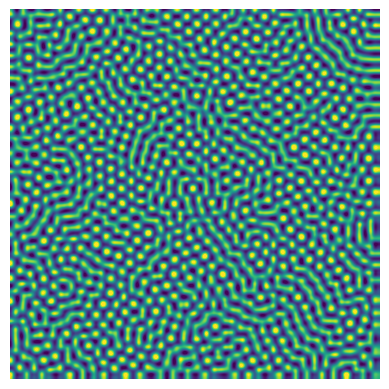

In [105]:
generate_map(result,L,size_partition)

<font size = 5> Periodic Boundary Conditions </font>

In [114]:
class parameters:
  def __init__(self,a,b,gamma,du,dv,size_partition,T,L):
    self.a = a
    self.b = b
    self.gamma = gamma
    self.du = du
    self.dv = dv
    self.size_partition = size_partition
    self.T = T
    self.L = L

  def values(self):
    dx = self.L / self.size_partition  # spatial step
    dt = 1*10**(-6)  # time step
    n = int(self.T / dt)  # total number of iterations
    return self.a,self.b,self.gamma,self.du,self.dv,self.size_partition,self.T,self.L,dx,dt,n

  def initial_conditions(self):
    U = np.random.rand(self.size_partition, self.size_partition)
    V = np.random.rand(self.size_partition, self.size_partition)
    return U,V
      
#Finite Difference 2D:

#Laplacian
@jit(nopython=True)
def laplacian(Z, dx):
    Z_lap = np.zeros_like(Z)
    for i in range(1, Z.shape[0] - 1):
        for j in range(1, Z.shape[1] - 1):
            Z_lap[i, j] = (Z[i-1, j] + Z[i+1, j] + Z[i, j-1] + Z[i, j+1] - 4 * Z[i, j]) / dx**2
    return Z_lap

#main
@jit(nopython=True)
def main_periodic(n, gamma, a, b, du, dv, dt, U, V):
    for i in range(n):
        # laplacian for U and V
        deltaU = laplacian(U, dx)
        deltaV = laplacian(V, dx)
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # Mesh change
        U[1:-1, 1:-1] = Uc + dt * (du * deltaU[1:-1, 1:-1] + gamma * (a - Uc + Uc**2 * Vc))
        V[1:-1, 1:-1] = Vc + dt * (dv * deltaV[1:-1, 1:-1] + gamma * (b - Uc**2 * Vc))

        # Periodic boundary conditions
        for Z in (U, V):
            Z[:, 0] = Z[:, -3] 
            Z[:, -1] = Z[:, 2]
            Z[0, :] = Z[-3, :]
            Z[-1, :] = Z[2, :]
            Z[1, :] = Z[-2, :]
            Z[:, 1] = Z[:, -2]
            
        if i == n - 1:
            return U

#Map
def generate_map(matrix,L,P):
    vmin = np.min(matrix)
    vmax = np.max(matrix)
    fig, ax = plt.subplots()
    ax.imshow(matrix[1:P+2,1:P+2], cmap = 'viridis',interpolation='spline16',extent=[0, L, 0, L],vmin=vmin, vmax=vmax)
    ax.set_axis_off()

schnakenberg = parameters(0.14,1.34,10000,1,20,100,0.2,1) #a,b,gamma,du,dv,size_partition,T,L

a,b,gamma,du,dv,size_partition,T,L,dx,dt,n= schnakenberg.values()

U,V = schnakenberg.initial_conditions()

result = main_periodic(n, gamma, a, b, du, dv, dt, U, V)

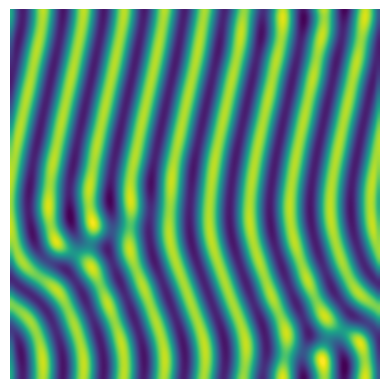

In [115]:
generate_map(result,L,size_partition)